# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
#Portfolio dataframe 
df1 = portfolio.copy()


In [3]:
#df1 structuring
temp = pd.get_dummies(df1.channels.apply(pd.Series).stack()).sum(level=0)
df1 = pd.concat([df1, temp], axis=1)
df1 = df1.drop(columns='channels')


C:\Users\Grant\AppData\Local\Temp\ipykernel_33440\985164131.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  temp = pd.get_dummies(df1.channels.apply(pd.Series).stack()).sum(level=0)


In [4]:
#Pulling data into dataframe
df2 = profile.copy()
df3 = transcript.copy()

In [5]:
#Making sure both id's are the same person
df3.rename(columns={'person': 'customer_id'}, inplace=True)
df2.rename(columns={'id': 'customer_id'}, inplace=True)

In [6]:
#rename id to offer id 
df1.rename(columns={'id': 'offer_id'}, inplace=True)

In [7]:
df3

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [8]:
#Extracing offer id and amount
df3['offer_id'] = [v['offer id'] if 'offer id' in v else None for v in df3['value']]
df3['amount'] = [v['amount'] if 'amount' in v else None for v in df3['value']]


In [9]:
#Dropping value after splitting 
df3 = df3.drop(columns='value')

In [10]:
#Replacing the none in ammount with 0
df3['amount'] = pd.to_numeric(df3['amount'], errors='coerce').fillna(0)


In [11]:
#splitting events into different columns
dummy = pd.get_dummies(df3['event'])
df3 = pd.concat([df3, dummy], axis=1 )

In [12]:
df3

,customer_id,event,time,offer_id,amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.00,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,0,1,0,0
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,3.53,0,0,0,1


In [13]:
#Merging df1 and df2 on customer ID
data = pd.merge(df2, df3, on='customer_id')

In [14]:
#Final Merge
data = pd.merge(data, df1, left_on='offer_id', right_on='offer_id', how='left')

In [15]:
data

,gender,age,customer_id,became_member_on,income,event,time,offer_id,amount,offer completed,...,offer viewed,transaction,reward,difficulty,duration,offer_type,email,mobile,social,web
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer received,168,2906b810c7d4411798c6938adc9daaa5,0.00,0,...,0,0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
1,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer viewed,216,2906b810c7d4411798c6938adc9daaa5,0.00,0,...,1,0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
2,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0,...,0,0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
3,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer viewed,348,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0,...,1,0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
4,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,transaction,360,None,0.35,0,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,F,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,offer completed,480,None,0.00,1,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,F,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,transaction,486,None,19.47,0,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,F,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,offer viewed,546,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0,...,1,0,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
306532,F,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,offer received,576,3f207df678b143eea3cee63160fa8bed,0.00,0,...,0,0,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0


In [16]:
#Changing none in gender to O 
data['gender'] = data['gender'].fillna('O')


In [17]:
#Converting Gender to numerical values
gender_dict = {'F':0, 'M':1, 'O':2}
data['gender'] = data['gender'].map(gender_dict)

In [18]:
#turnining offer_id into a binary value where 1 signifies an offer_id and 0 none
data['offer_id'] = data['offer_id'].notnull().astype(int)


In [19]:
#making all nulls for email, mobile, social, and web 0
data['email'] = data['email'].fillna(0)
data['mobile'] = data['mobile'].fillna(0)
data['social'] = data['social'].fillna(0)
data['web'] = data['web'].fillna(0)


In [20]:
data

,gender,age,customer_id,became_member_on,income,event,time,offer_id,amount,offer completed,...,offer viewed,transaction,reward,difficulty,duration,offer_type,email,mobile,social,web
0,2,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer received,168,1,0.00,0,...,0,0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
1,2,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer viewed,216,1,0.00,0,...,1,0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
2,2,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer received,336,1,0.00,0,...,0,0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
3,2,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer viewed,348,1,0.00,0,...,1,0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
4,2,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,transaction,360,0,0.35,0,...,0,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,0,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,offer completed,480,0,0.00,1,...,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
306530,0,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,transaction,486,0,19.47,0,...,0,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
306531,0,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,offer viewed,546,1,0.00,0,...,1,0,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
306532,0,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,offer received,576,1,0.00,0,...,0,0,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0


In [21]:
#begining exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns

print(data.describe())

              gender            age  became_member_on         income  \
count  306534.000000  306534.000000      3.065340e+05  272762.000000   
mean        0.754161      60.909367      2.016545e+07   64337.000755   
std         0.657008      26.032030      1.190460e+04   21243.762941   
min         0.000000      18.000000      2.013073e+07   30000.000000   
25%         0.000000      43.000000      2.016032e+07   48000.000000   
50%         1.000000      57.000000      2.017041e+07   62000.000000   
75%         1.000000      72.000000      2.017113e+07   78000.000000   
max         2.000000     118.000000      2.018073e+07  120000.000000   

                time       offer_id         amount  offer completed  \
count  306534.000000  306534.000000  306534.000000    306534.000000   
mean      366.382940       0.437152       5.792023         0.109544   
std       200.326314       0.496035      21.337137         0.312321   
min         0.000000       0.000000       0.000000         0.000000

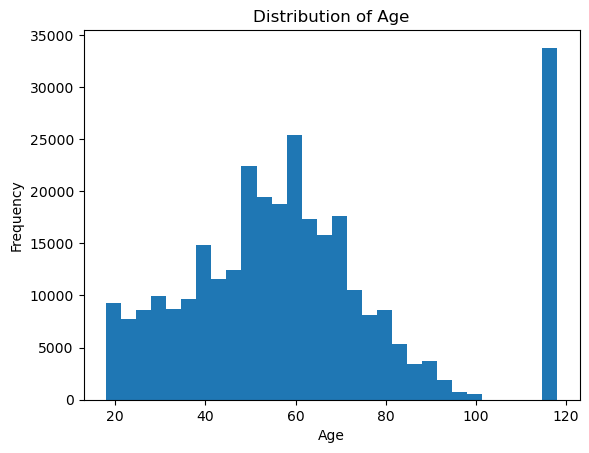

In [22]:
# Looking at the distribution of age
plt.hist(data['age'], bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


In [23]:
#Double checking how many times 118 appears in the age column
count = data['age'].astype(str).str.count('118').sum()
print("Number 118 year olds:", count)

Number 118 year olds: 33772


In [24]:
# Drop rows where the age is 118, unlikely that 118 is the most common age in the data so it is most likely bad data
data = data[data['age'] != 118]
data = data.reset_index(drop=True)

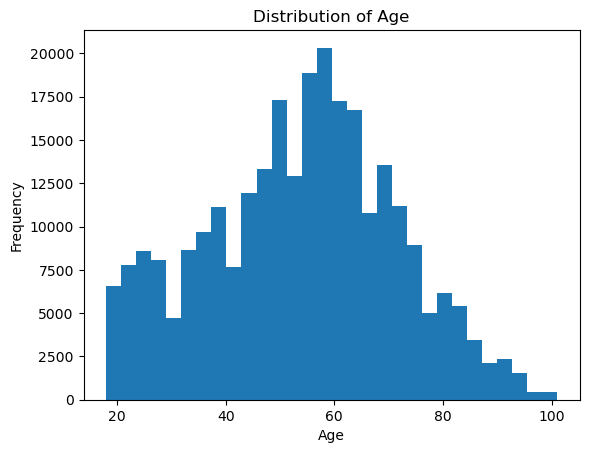

In [25]:
# Looking at the distribution of age after dropping 118
plt.hist(data['age'], bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

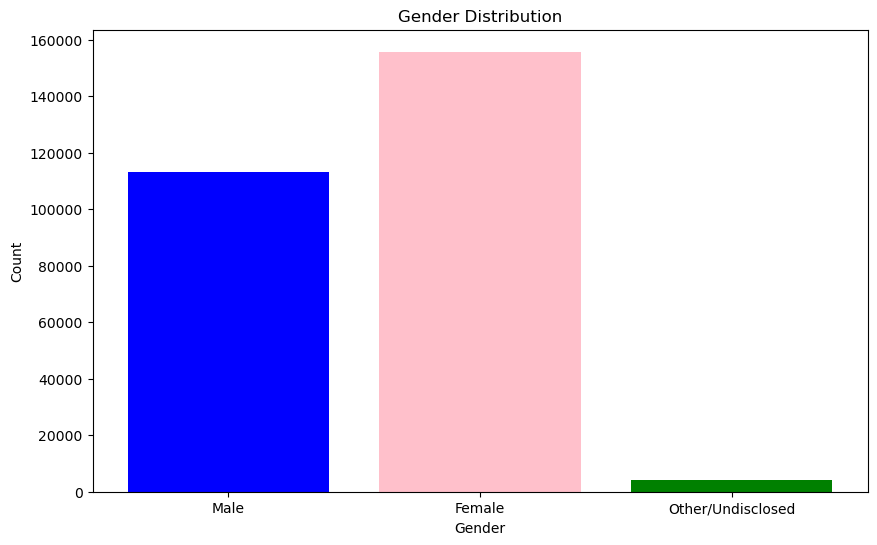

In [26]:
#Looking at gender distribution
gender_counts = data['gender'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(gender_counts.index, gender_counts.values, color=['pink', 'blue', 'green'], tick_label=['Female', 'Male', 'Other/Undisclosed'])

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')

plt.show()

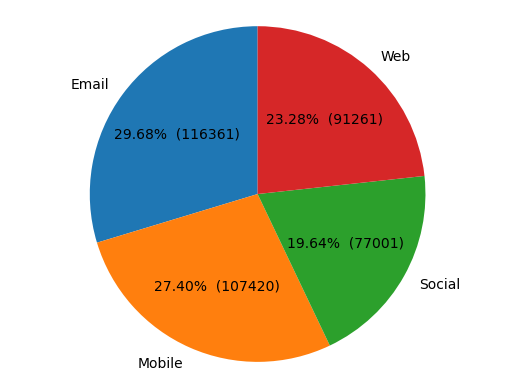

In [27]:
#looking at the differnces in ads via email, mobile, social, and web
email_sum = data['email'].sum()
mobile_sum = data['mobile'].sum()
social_sum = data['social'].sum()
web_sum = data['web'].sum()

sizes = [email_sum, mobile_sum, social_sum, web_sum]
labels = ['Email', 'Mobile', 'Social', 'Web']

def custom_autopct(pct):
    total = sum(sizes)
    val = int(round(pct*total/100.0))
    return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=custom_autopct, startangle=90)
ax1.axis('equal') 

plt.show()

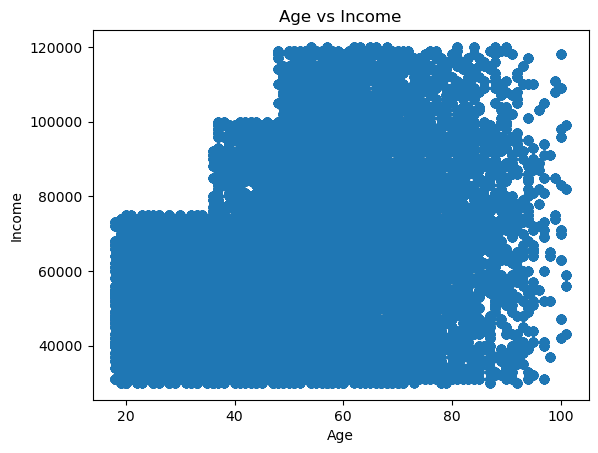

In [28]:
# reviewing the corrilation between age and income
plt.scatter(data['age'], data['income'])
plt.title('Age vs Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()


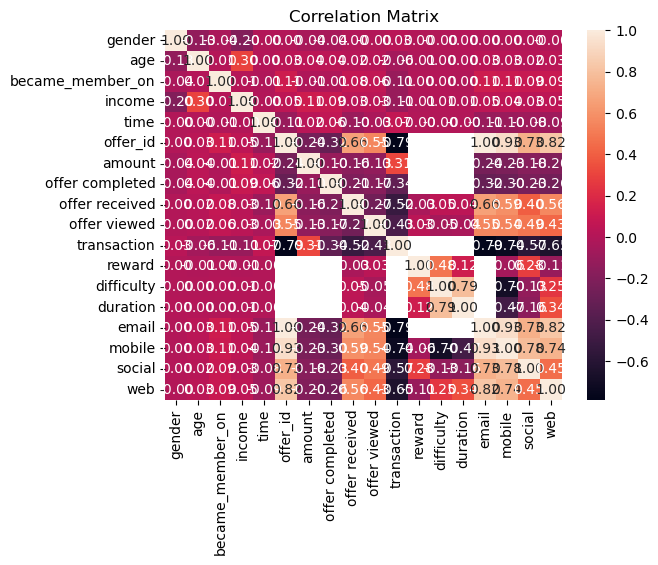

In [29]:
# Reviewing overall correlation matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [30]:
# Target variable, the goal is to predict if the customer will spend greater than $10
data['target'] = data['amount'].apply(lambda x: 1 if x > 10 else 0)

In [31]:
# Define features and target variables
X = data[['gender', 'email', 'mobile', 'social', 'web', 'age','income']]
y = data['target']


In [32]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [33]:
# Spliting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [34]:
# Create the model
classifier = RandomForestClassifier(n_estimators=20, random_state=0)
classifier.fit(X_train, y_train)


RandomForestClassifier(n_estimators=20, random_state=0)

In [35]:
# Predicting the test set results
y_pred = classifier.predict(X_test)

In [36]:
# Evaluating the model
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))


Confusion Matrix: [[36543  4924]
 [ 4137  8949]]
Accuracy: 0.8339046431910252


In [37]:
#Further model evaluation
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.88      0.89     41467
           1       0.65      0.68      0.66     13086

    accuracy                           0.83     54553
   macro avg       0.77      0.78      0.78     54553
weighted avg       0.84      0.83      0.84     54553



In [40]:
#Trying a neural network model to see if we can improve 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [44]:
#Definining Keras Model
model = Sequential()
model.add(Dense(12, input_dim=7, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [46]:
#Compling the Keras Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
#fitting the Keras Model
model.fit(X_train, y_train, epochs=11, batch_size=32)

Epoch 1/11
6820/6820 [==============================] - 6s 844us/step - loss: 0.3394 - accuracy: 0.8236
Epoch 2/11
6820/6820 [==============================] - 5s 793us/step - loss: 0.3340 - accuracy: 0.8273
Epoch 3/11
6820/6820 [==============================] - 6s 814us/step - loss: 0.3337 - accuracy: 0.8275
Epoch 4/11
6820/6820 [==============================] - 5s 767us/step - loss: 0.3334 - accuracy: 0.8276
Epoch 5/11
6820/6820 [==============================] - 5s 780us/step - loss: 0.3333 - accuracy: 0.8282
Epoch 6/11
6820/6820 [==============================] - 5s 784us/step - loss: 0.3332 - accuracy: 0.8280
Epoch 7/11
6820/6820 [==============================] - 5s 776us/step - loss: 0.3331 - accuracy: 0.8278
Epoch 8/11
6820/6820 [==============================] - 5s 782us/step - loss: 0.3331 - accuracy: 0.8281
Epoch 9/11
6820/6820 [==============================] - 5s 779us/step - loss: 0.3330 - accuracy: 0.8284
Epoch 10/11
6820/6820 [==============================] - 6s 851u

In [48]:
#evaluating the Keras Model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1705/1705 [==============================] - 1s 636us/step - loss: 0.3344 - accuracy: 0.8284
Accuracy: 82.84


In [49]:
#prepping for further evaluation
y_pred_prob = model.predict(X_test)


1705/1705 [==============================] - 1s 540us/step


In [50]:
# Convert probabilities
y_pred = np.where(y_pred_prob > 0.5, 1, 0) 

In [52]:
#Importing to attempt additional improvement 
from tensorflow.keras.layers import Dropout


In [53]:
#redefining model back to base
model = Sequential()


In [54]:
#adding layers and adjusting neurons
model.add(Dense(24, input_dim=7, activation='relu')) 
model.add(Dropout(0.2)) 
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [55]:
#compiling model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
#fitting model with updates
model.fit(X_train, y_train, epochs=11, batch_size=32)

Epoch 1/11
6820/6820 [==============================] - 7s 881us/step - loss: 0.3400 - accuracy: 0.8229
Epoch 2/11
6820/6820 [==============================] - 6s 880us/step - loss: 0.3351 - accuracy: 0.8268
Epoch 3/11
6820/6820 [==============================] - 6s 877us/step - loss: 0.3345 - accuracy: 0.8276
Epoch 4/11
6820/6820 [==============================] - 6s 871us/step - loss: 0.3342 - accuracy: 0.8276
Epoch 5/11
6820/6820 [==============================] - 6s 883us/step - loss: 0.3339 - accuracy: 0.8282
Epoch 6/11
6820/6820 [==============================] - 6s 877us/step - loss: 0.3338 - accuracy: 0.8278
Epoch 7/11
6820/6820 [==============================] - 6s 884us/step - loss: 0.3338 - accuracy: 0.8278
Epoch 8/11
6820/6820 [==============================] - 6s 888us/step - loss: 0.3339 - accuracy: 0.8279
Epoch 9/11
6820/6820 [==============================] - 6s 874us/step - loss: 0.3337 - accuracy: 0.8276
Epoch 10/11
6820/6820 [==============================] - 6s 883u

In [57]:
#evaluating the updated Keras Model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1705/1705 [==============================] - 1s 667us/step - loss: 0.3348 - accuracy: 0.8283
Accuracy: 82.83


In [58]:
#importing additional libraries for further improvement, theory is the model is overfitting
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [59]:
#Redefining Keras Model, adding L2 regularization, dropout layer, and early stopping
model = Sequential()
model.add(Dense(16, input_dim=7, activation='relu', kernel_regularizer=l2(0.01))) 
model.add(Dropout(0.2)) 
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01))) 
model.add(Dense(1, activation='sigmoid'))

In [60]:
#defining early stopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=10) 

In [61]:
#Compiling new model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [62]:
#fiting improved model, increased epochs
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2, callbacks=[early_stopping]) 


Epoch 1/40
5456/5456 [==============================] - 6s 1ms/step - loss: 0.3986 - accuracy: 0.8118 - val_loss: 0.3555 - val_accuracy: 0.8285
Epoch 2/40
5456/5456 [==============================] - 5s 979us/step - loss: 0.3552 - accuracy: 0.8226 - val_loss: 0.3512 - val_accuracy: 0.8266
Epoch 3/40
5456/5456 [==============================] - 5s 975us/step - loss: 0.3519 - accuracy: 0.8241 - val_loss: 0.3493 - val_accuracy: 0.8285
Epoch 4/40
5456/5456 [==============================] - 5s 991us/step - loss: 0.3507 - accuracy: 0.8244 - val_loss: 0.3474 - val_accuracy: 0.8279
Epoch 5/40
5456/5456 [==============================] - 6s 1ms/step - loss: 0.3493 - accuracy: 0.8241 - val_loss: 0.3469 - val_accuracy: 0.8278
Epoch 6/40
5456/5456 [==============================] - 5s 1000us/step - loss: 0.3485 - accuracy: 0.8239 - val_loss: 0.3466 - val_accuracy: 0.8258
Epoch 7/40
5456/5456 [==============================] - 6s 1ms/step - loss: 0.3483 - accuracy: 0.8231 - val_loss: 0.3462 - val_

In [63]:
#evaluating the model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1705/1705 [==============================] - 1s 654us/step - loss: 0.3450 - accuracy: 0.8264
Accuracy: 82.64


In [65]:
#Attempting same model but lowering batch size
model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.2, callbacks=[early_stopping]) 


Epoch 1/10
17457/17457 [==============================] - 17s 976us/step - loss: 0.3456 - accuracy: 0.8225 - val_loss: 0.3440 - val_accuracy: 0.8252
Epoch 2/10
17457/17457 [==============================] - 17s 972us/step - loss: 0.3456 - accuracy: 0.8215 - val_loss: 0.3411 - val_accuracy: 0.8296
Epoch 3/10
17457/17457 [==============================] - 17s 977us/step - loss: 0.3457 - accuracy: 0.8214 - val_loss: 0.3464 - val_accuracy: 0.8207
Epoch 4/10
17457/17457 [==============================] - 17s 975us/step - loss: 0.3459 - accuracy: 0.8222 - val_loss: 0.3480 - val_accuracy: 0.8183
Epoch 5/10
17457/17457 [==============================] - 17s 983us/step - loss: 0.3459 - accuracy: 0.8220 - val_loss: 0.3419 - val_accuracy: 0.8267
Epoch 6/10
17457/17457 [==============================] - 17s 984us/step - loss: 0.3459 - accuracy: 0.8221 - val_loss: 0.3405 - val_accuracy: 0.8288
Epoch 7/10
17457/17457 [==============================] - 17s 1000us/step - loss: 0.3457 - accuracy: 0.823

In [66]:
#evaluating the model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1705/1705 [==============================] - 1s 689us/step - loss: 0.3451 - accuracy: 0.8239
Accuracy: 82.39


In [67]:
#resetting to original Neural Model as it was most accurate
model = Sequential()
model.add(Dense(12, input_dim=7, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [68]:
#compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [69]:
#fitting the Keras Model
model.fit(X_train, y_train, epochs=11, batch_size=32)

Epoch 1/11
6820/6820 [==============================] - 6s 783us/step - loss: 0.3461 - accuracy: 0.8207
Epoch 2/11
6820/6820 [==============================] - 6s 843us/step - loss: 0.3341 - accuracy: 0.8271
Epoch 3/11
6820/6820 [==============================] - 5s 762us/step - loss: 0.3338 - accuracy: 0.8273
Epoch 4/11
6820/6820 [==============================] - 5s 769us/step - loss: 0.3336 - accuracy: 0.8281
Epoch 5/11
6820/6820 [==============================] - 5s 766us/step - loss: 0.3336 - accuracy: 0.8279
Epoch 6/11
6820/6820 [==============================] - 5s 769us/step - loss: 0.3335 - accuracy: 0.8275
Epoch 7/11
6820/6820 [==============================] - 5s 786us/step - loss: 0.3336 - accuracy: 0.8277
Epoch 8/11
6820/6820 [==============================] - 5s 795us/step - loss: 0.3335 - accuracy: 0.8276
Epoch 9/11
6820/6820 [==============================] - 5s 776us/step - loss: 0.3335 - accuracy: 0.8279
Epoch 10/11
6820/6820 [==============================] - 6s 826u

In [70]:
#testing to see if lower batch size improves accuracy
model.fit(X_train, y_train, epochs=11, batch_size=10)

Epoch 1/11
21821/21821 [==============================] - 17s 788us/step - loss: 0.3339 - accuracy: 0.8275
Epoch 2/11
21821/21821 [==============================] - 17s 796us/step - loss: 0.3337 - accuracy: 0.8277
Epoch 3/11
21821/21821 [==============================] - 17s 794us/step - loss: 0.3337 - accuracy: 0.8280
Epoch 4/11
21821/21821 [==============================] - 17s 792us/step - loss: 0.3336 - accuracy: 0.8279
Epoch 5/11
21821/21821 [==============================] - 17s 785us/step - loss: 0.3335 - accuracy: 0.8278
Epoch 6/11
21821/21821 [==============================] - 18s 830us/step - loss: 0.3335 - accuracy: 0.8277
Epoch 7/11
21821/21821 [==============================] - 18s 828us/step - loss: 0.3333 - accuracy: 0.8277
Epoch 8/11
21821/21821 [==============================] - 17s 800us/step - loss: 0.3332 - accuracy: 0.8280
Epoch 9/11
21821/21821 [==============================] - 18s 802us/step - loss: 0.3331 - accuracy: 0.8281
Epoch 10/11
21821/21821 [============

In [71]:
#evaluating the model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1705/1705 [==============================] - 1s 642us/step - loss: 0.3342 - accuracy: 0.8269
Accuracy: 82.69


In [72]:
#keeping model due to highest accuracy
history = model.fit(X_train, y_train, validation_split=0.2, epochs=11, batch_size=10)


Epoch 1/11
17457/17457 [==============================] - 16s 943us/step - loss: 0.3329 - accuracy: 0.8276 - val_loss: 0.3334 - val_accuracy: 0.8296
Epoch 2/11
17457/17457 [==============================] - 17s 978us/step - loss: 0.3329 - accuracy: 0.8275 - val_loss: 0.3332 - val_accuracy: 0.8288
Epoch 3/11
17457/17457 [==============================] - 17s 946us/step - loss: 0.3328 - accuracy: 0.8280 - val_loss: 0.3330 - val_accuracy: 0.8292
Epoch 4/11
17457/17457 [==============================] - 17s 950us/step - loss: 0.3329 - accuracy: 0.8277 - val_loss: 0.3328 - val_accuracy: 0.8292
Epoch 5/11
17457/17457 [==============================] - 17s 950us/step - loss: 0.3328 - accuracy: 0.8280 - val_loss: 0.3333 - val_accuracy: 0.8283
Epoch 6/11
17457/17457 [==============================] - 17s 953us/step - loss: 0.3329 - accuracy: 0.8276 - val_loss: 0.3331 - val_accuracy: 0.8296
Epoch 7/11
17457/17457 [==============================] - 17s 953us/step - loss: 0.3329 - accuracy: 0.8279

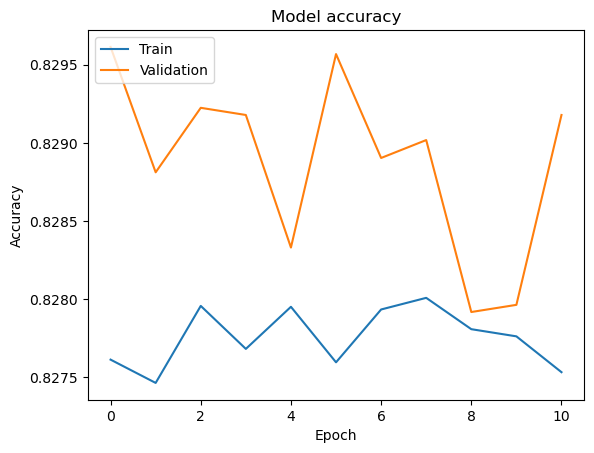

In [73]:
#Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


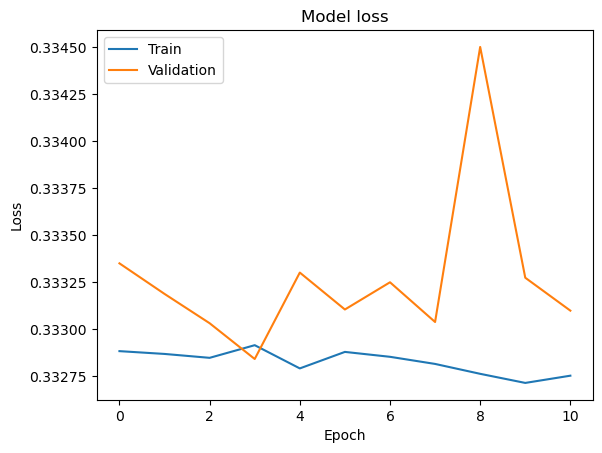

In [74]:
# plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()